In [1]:
from fastai.vision.all import *

In [2]:
Path.cwd()

Path('/media/fahad/TOSHIBA EXT/From E/From Dell/pyProgs/fastai_course/self-driving-cars/road_segmentation')

In [3]:
BASE_DIR = Path.cwd().parent

In [4]:
BASE_DIR

Path('/media/fahad/TOSHIBA EXT/From E/From Dell/pyProgs/fastai_course/self-driving-cars')

In [8]:
data_path = BASE_DIR / 'datasets/kitti_road'

In [9]:
data_path

Path('/media/fahad/TOSHIBA EXT/From E/From Dell/pyProgs/fastai_course/self-driving-cars/datasets/kitti_road')

<AxesSubplot:>

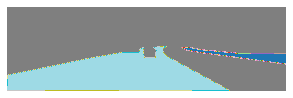

In [43]:
mask_file = data_path / 'training/gt_image_2/umm_road_000038.png'
mask = PILMask.create(mask_file)
mask.show(figsize=(5, 5), alpha=1.0)

In [44]:
tensor(mask)

tensor([[76, 76, 76,  ..., 76, 76, 76],
        [76, 76, 76,  ..., 76, 76, 76],
        [76, 76, 76,  ..., 76, 76, 76],
        ...,
        [76, 76, 76,  ..., 76, 76, 76],
        [76, 76, 76,  ..., 76, 76, 76],
        [76, 76, 76,  ..., 76, 76, 76]], dtype=torch.uint8)

In [11]:
unique_values = np.unique(mask)
print(unique_values)

[  0  76 105]


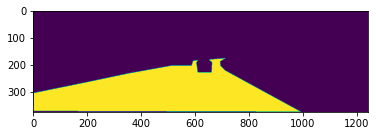

In [12]:
mask_copy = np.where(np.array(mask) == 105, 1, 0)
plt.imshow(mask_copy)

In [13]:
lbl_names = get_image_files(data_path / 'training/gt_image_2')
print(type(lbl_names))
lbl_names

<class 'fastcore.foundation.L'>


(#384) [Path('/media/fahad/TOSHIBA EXT/From E/From Dell/pyProgs/fastai_course/self-driving-cars/datasets/kitti_road/training/gt_image_2/umm_road_000000.png'),Path('/media/fahad/TOSHIBA EXT/From E/From Dell/pyProgs/fastai_course/self-driving-cars/datasets/kitti_road/training/gt_image_2/umm_road_000001.png'),Path('/media/fahad/TOSHIBA EXT/From E/From Dell/pyProgs/fastai_course/self-driving-cars/datasets/kitti_road/training/gt_image_2/umm_road_000002.png'),Path('/media/fahad/TOSHIBA EXT/From E/From Dell/pyProgs/fastai_course/self-driving-cars/datasets/kitti_road/training/gt_image_2/umm_road_000003.png'),Path('/media/fahad/TOSHIBA EXT/From E/From Dell/pyProgs/fastai_course/self-driving-cars/datasets/kitti_road/training/gt_image_2/umm_road_000004.png'),Path('/media/fahad/TOSHIBA EXT/From E/From Dell/pyProgs/fastai_course/self-driving-cars/datasets/kitti_road/training/gt_image_2/umm_road_000005.png'),Path('/media/fahad/TOSHIBA EXT/From E/From Dell/pyProgs/fastai_course/self-driving-cars/data

In [14]:
def n_codes(fnames, is_partial=False):
    "Gather the codes from a list of `fnames`"
    vals = set()
    if is_partial:
        random.shuffle(fnames)
        fnames = fnames[:10]
    for fname in fnames:
        msk = np.array(PILMask.create(fname))
        for val in np.unique(msk):
            if val not in vals:
                vals.add(val)
    vals = list(vals)
    p2c = dict()
    for i,val in enumerate(vals):
        p2c[i] = vals[i]
    return p2c

In [15]:
p2c = n_codes(lbl_names)
p2c

{0: 0, 1: 105, 2: 76, 3: 29}

In [52]:
# codes = ['Other Lane', 'Road', 'Background', 'gutter']
codes = array(['Background', 'Road'])

In [58]:
# def get_msk(fn, pix2class):
#     "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
#     fn = fn.parent.parent/'gt_image_2'/f'{fn.stem.split("_")[0]}_road_{fn.stem.split("_")[-1]}{fn.suffix}'
#     msk = np.array(PILMask.create(fn))
# #     mx = np.max(msk)
#     for i, val in enumerate(pix2class):
#         msk[msk==pix2class[i]] = val
#     return PILMask.create(msk)

def get_msk(fn, pix2class):
    "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
    fn = fn.parent.parent/'gt_image_2'/f'{fn.stem.split("_")[0]}_road_{fn.stem.split("_")[-1]}{fn.suffix}'
    msk = np.array(PILMask.create(fn))
#     mx = np.max(msk)
    for i, val in enumerate(pix2class):
        if val == 1:
            msk[msk==pix2class[i]] = val
        else:
            msk[msk==pix2class[i]] = 0
#     return PILMask.create(msk)
    return msk

In [59]:
get_y = lambda o: get_msk(o, p2c)

[0 1]


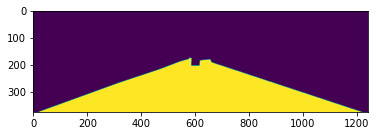

In [60]:
file_names = get_image_files(data_path / 'training/image_2')
test_mask = get_y(file_names[9])
plt.imshow(np.array(test_mask))
print(np.unique(test_mask))

In [61]:
kitty = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
        get_items=get_image_files,
        splitter=RandomSplitter(),
        get_y=get_y,
        item_tfms=Resize(256))
# kitty = DataBlock(
#         get_items=get_image_files,
#         get_y=lambda o: o.parent.parent/'gt_image_2'/f'{o.stem.split("_")[0]}_lane_{o.stem.split("_")[-1]}{o.suffix}',
#         )

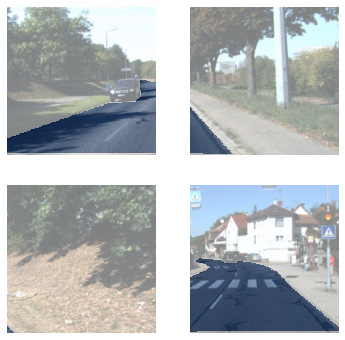

In [71]:
dls = kitty.dataloaders(data_path / 'training/image_2', bs=4)
dls.show_batch(cmap='Blues', vmin=0, vmax=1)

In [72]:
dls.vocab = codes

In [73]:
learn = unet_learner(dls, resnet34, metrics=Dice)

In [74]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,dice,time
0,0.302479,1.123303,0.000000,00:14


epoch,train_loss,valid_loss,dice,time
0,0.262217,0.871604,0.755403,00:16
1,0.172952,0.164895,0.929647,00:17
2,0.099911,0.138256,0.930268,00:24


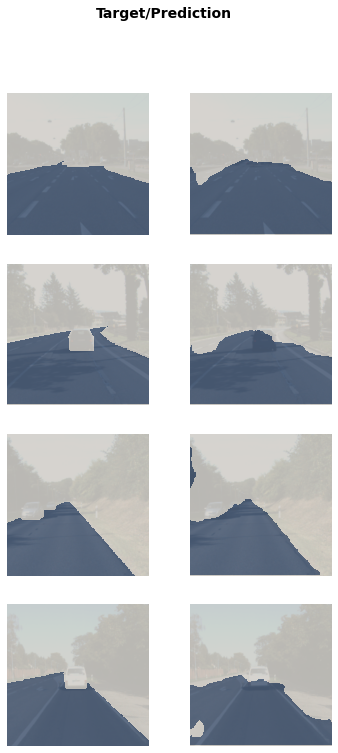

In [75]:
learn.show_results(cmap='Blues', vmin=0, vmax=1)

In [67]:
res = learn.predict(data_path / 'testing/image_2/um_000012.png')

<AxesSubplot:>

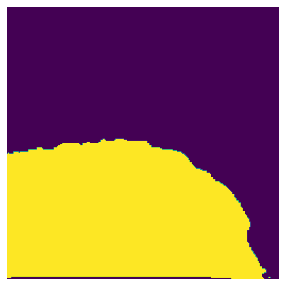

In [68]:
show_image(res[0])

<AxesSubplot:>

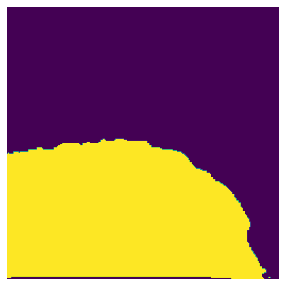

In [69]:
show_image(res[1])

<AxesSubplot:>

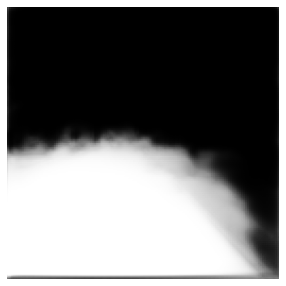

In [80]:
res[2][1].show(cmap='gray')

In [79]:
res[0].shape

torch.Size([256, 256])

In [84]:
learn.save('initial')

Path('models/initial.pth')

In [85]:
learn.load('initial')

/home/fahad/miniconda3/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [86]:
res = learn.predict(data_path / 'testing/image_2/um_000012.png')

<AxesSubplot:>

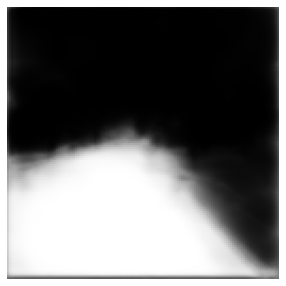

In [87]:
res[2][1].show(cmap='gray')

In [88]:
res[2][1].shape

torch.Size([256, 256])